In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
# Load Iris Flowers dataset

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
colNames = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']
irisFlowersDb = pd.read_csv(url, names=colNames)

In [35]:
# Analising the dataset
#shape

irisFlowersDb.shape

(150, 5)

In [36]:
#first 5 rows

irisFlowersDb.head()

,sepal-length,sepal-width,petal-length,petal-width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [37]:
#checking for missing values and data type

irisFlowersDb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal-length  150 non-null    float64
 1   sepal-width   150 non-null    float64
 2   petal-length  150 non-null    float64
 3   petal-width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [38]:
# Statistical summary

irisFlowersDb.describe()

,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


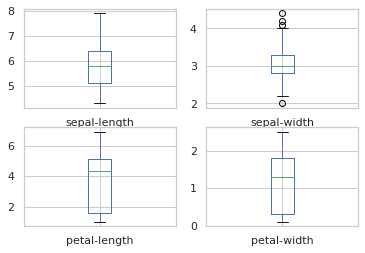

In [39]:
# box and whisker plots

irisFlowersDb.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

In [40]:
# Distribution

irisFlowersDb['species'].value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        50
Name: species, dtype: int64

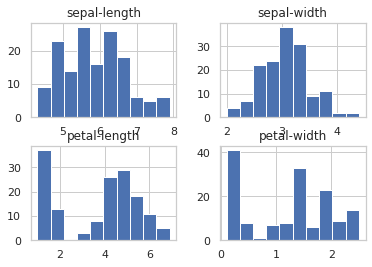

In [41]:
# Histograms

irisFlowersDb.hist()
plt.show()

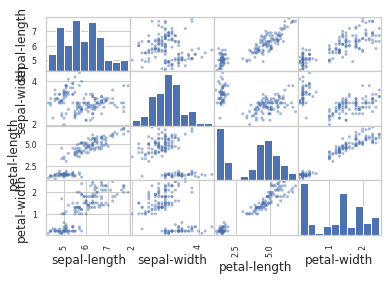

In [42]:
# Scatter Matrix Plot

pd.plotting.scatter_matrix(irisFlowersDb, grid = True, diagonal = 'hist')
plt.show()

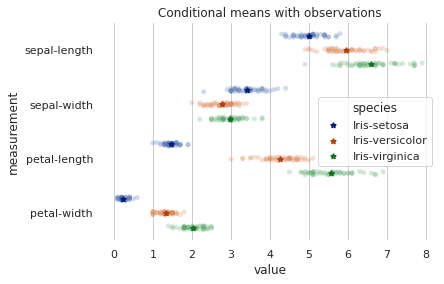

In [43]:
# Conditional means with observations

# "Melt" the dataset to "long-form" or "tidy" representation
measurement = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
meltIrisFlowersDb = pd.melt(irisFlowersDb, id_vars = ['species'], value_vars = measurement, var_name='measurement')

# Initialize the figure
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
#alpha is the desity of the color
sns.stripplot(x = 'value', y = 'measurement', hue = 'species', data = meltIrisFlowersDb, dodge = True, alpha=.25, zorder = 1)

# Show the conditional means
# Where does the dodge = .532 comes from?
sns.pointplot(x = 'value', y = 'measurement', hue = 'species', data = meltIrisFlowersDb, join = False, palette = 'dark', scale=.75,
             ci = None, dodge = .532, markers = '*')

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:6], labels[3:6], title='species', loc="best")

plt.title('Conditional means with observations')
plt.show()

# **Evaluating some algorithms**

In [44]:
# Prediction Target
y = irisFlowersDb['species']

# Features
features = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
X = irisFlowersDb[features]

# Slipt Training Data (80% training / 20% validation)
trainX, valX, trainY, valY = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [46]:
# Define Model
#K-Nearest Neighbors (KNN).
#Random Forest Classifier (RFC).
#Decision Tree Classifier (DTC).

# Spot Check Algorithms
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DTC', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits = 10, random_state = 0, shuffle = True)
    cv_results = cross_val_score(model, trainX, trainY, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

KNN: 0.958333 (0.041667)
RFC: 0.950000 (0.040825)
DTC: 0.933333 (0.050000)


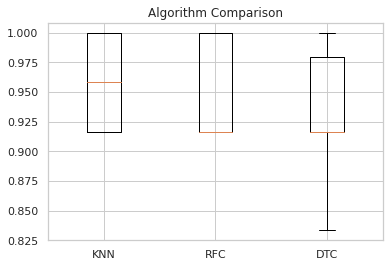

In [47]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [48]:
# Define Model KNN
model = KNeighborsClassifier()

#Fit Model
model.fit(trainX, trainY)

#Predict
predictions = model.predict(valX)

# Evaluate predictions
print(accuracy_score(valY, predictions))
print(confusion_matrix(valY, predictions))
print(classification_report(valY, predictions))

1.0
[[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00         6

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30

